In [1]:
import random
import torch
import pandas as pd
import numpy as np
import json
import os
import copy
from torch import dropout, nn
from torch.optim import AdamW, Adam
from transformers import AutoModel, AutoTokenizer, AutoModelForTokenClassification, AutoModelForSequenceClassification
from transformers import RobertaForSequenceClassification
from transformers import RobertaModel
from transformers import get_scheduler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn import metrics as metrics
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from tqdm.auto import tqdm
import re
from nltk.tokenize import sent_tokenize


random.seed(42)
reprocess_raw =  False # whether to re-read the raw data and create combo files
reshuffle_data = False  # whether to reprocess the document lists


##### HYPERPARAMETERS

data_size_reduce = 1 # multiplier for making small datasets 
                     # (only works if reshuffle_data=True)

batch_size = 8 # documents

learning_rate = 7e-5 # sets AdamW optimizaiton learning rate
                     # scales scales with each training loop if scheduler is on

dropout_rate = 0.03 # sets same dropout for roberta and for classification layer

normalizer_before_class = False # toggle the normalizer before the classification layer
use_lr_scheduler = False  # toggle the linear learning rate scheduler

n_epochs = 8 # baseline probably minimizes after 4 Epochs'

##### end HPs

task_map = {'Quantity':1,'MeasuredProperty':2,'MeasuredEntity':3,'Qualifier':4, 'Unit':5}
num_classes = len(task_map)

model_name = 'roberta-base'
# model_name = 'allenai/biomed_roberta_base'
# model_name = 'allenai/cs_roberta_base'


device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# device = 'cpu' # uncomment this to make debugging models easier
                 # because CPU errors are more clear

run_name = model_name.split('/')[-1] +'_bs-'+str(batch_size)+\
                                        '_lr-'+str(learning_rate)+\
                                        '_drop-'+str(dropout_rate)+\
                                        '_norm-'+str(normalizer_before_class)[0]+\
                                        '_sched-'+str(use_lr_scheduler)[0]

print(run_name)

roberta-base_bs-8_lr-7e-05_drop-0.03_norm-F_sched-F


In [2]:
currentdir = os.getcwd() # ~/MeasEval/baselines

combopath_txt = os.path.join(currentdir, "../data/raw/combo/text/")
combopath_annot = os.path.join(currentdir, "../data/raw/combo/tsv/")

interimpath = os.path.join(currentdir, "../data/interim/")

outputpath = os.path.join(currentdir, "../data/output/")

runoutpath = os.path.join(outputpath,run_name+'/')

In [3]:
runoutpath

'/home/sam/MeasEval/baselines/../data/output/roberta-base_bs-8_lr-7e-05_drop-0.03_norm-F_sched-F/'

In [4]:
try: os.makedirs(runoutpath)
except: pass

In [5]:
def process_raw_txt(docs):
    processesd_txt = {}
    remove_markers = True

    cnt_toks = {"figs.": 0, "fig.": 0, "et al.": 0,
            "ref.": 0, "eq.": 0, "e.g.": 0,
            "i.e.": 0, "nos.": 0, "no.": 0,
            "spp.": 0
            }
    regex_end_checker = [".*[a-zA-Z]figs\.$", 
                        ".*[a-zA-Z]fig\.$",
                        ".*[a-zA-Z]et al\.$",
                        ".*[a-zA-Z]ref\.$",
                        ".*[a-zA-Z]eq\.$",
                        ".*[a-zA-Z]e\.g\.$",
                        ".*[a-zA-Z]i\.e\.$",
                        ".*[a-zA-Z]nos\.$",
                        ".*[a-zA-Z]no\.$",
                        ".*[a-zA-Z]spp\.$",
                        # figs., fig., et al., Ref., Eq., e.g., i.e., Nos., No., spp.
                    ]

    assert len(cnt_toks) == len(regex_end_checker)

    for docId, doc in docs.items():
        flag = False
        sentences = sent_tokenize(doc)

        fixed_sentence_tokens = []
        curr_len = 0
        for s in sentences:
            if flag == True:
                assert s[0] != ' '
                white_length = doc[curr_len:].find(s[0])

                prev_len = len(fixed_sentence_tokens[-1])
                fixed_sentence_tokens[-1] = fixed_sentence_tokens[-1] + (" "*white_length) + s

                assert fixed_sentence_tokens[-1][prev_len+white_length] == doc[curr_len+white_length], (fixed_sentence_tokens[-1], doc, curr_len, tmp_this_sent_len)
                tmp_this_sent_len = white_length + len(s)
                assert fixed_sentence_tokens[-1][-1] == doc[curr_len+tmp_this_sent_len-1], (fixed_sentence_tokens[-1], doc, curr_len, tmp_this_sent_len)
                curr_len += tmp_this_sent_len
            else:
                if len(fixed_sentence_tokens) != 0:
                    assert s[0] != ' '
                    white_length = doc[curr_len:].find(s[0])
                    fixed_sentence_tokens.append( (" "*white_length) + s )
                else:
                    fixed_sentence_tokens.append(s)
                assert fixed_sentence_tokens[-1][0] == doc[curr_len], (fixed_sentence_tokens, doc, curr_len, tmp_this_sent_len)
                tmp_this_sent_len = len(fixed_sentence_tokens[-1])
                assert fixed_sentence_tokens[-1][-1] == doc[curr_len+tmp_this_sent_len-1], (fixed_sentence_tokens[-1], doc, curr_len, tmp_this_sent_len)
                curr_len += tmp_this_sent_len

            lower_cased_s = fixed_sentence_tokens[-1].lower()
            flag = False
            if remove_markers:
                for i, k in enumerate(cnt_toks):
                    this_regex_pattern = regex_end_checker[i]
                    if lower_cased_s.endswith(k) and re.match(this_regex_pattern, lower_cased_s) == None:
                        cnt_toks[k] += 1
                        flag = True
                        break

        processesd_txt[docId] = ''.join(fixed_sentence_tokens)
    return processesd_txt


In [6]:
def read_data(reprocess_raw = False):

    if reprocess_raw == True:
        docIds = []
        combo_txt = {}
        for fn in os.listdir(combopath_txt):
            docIds.append(fn[:-4])
            path = combopath_txt+fn
            with open(path) as textfile:
                    text = textfile.read()
                    #[:-4] strips off the .txt to get the id
                    combo_txt[fn[:-4]] = text

        combo_annot = pd.DataFrame()
        for fn in os.listdir(combopath_annot):
            path = combopath_annot+fn
            file = pd.read_csv(path,delimiter='\t',encoding='utf-8')
            combo_annot = pd.concat([combo_annot, file],ignore_index=True)

        combo_txt = process_raw_txt(combo_txt)
        assert docIds == list(combo_txt.keys()), (len(docIds), len(list(combo_txt.keys())))

        with open(interimpath+'combo_txt.json','w') as f:
            json.dump(combo_txt, f)

        combo_annot.to_csv(interimpath+'combo_annot.csv')

        return docIds, combo_txt, combo_annot
    else:
        combo_annot = pd.read_csv(interimpath+'combo_annot.csv')

        with open(interimpath+'combo_txt.json','r') as f:
            combo_txt = json.load(f)

        docIds = list(combo_txt.keys())
    
        return docIds, combo_txt, combo_annot

In [7]:
combo_docs, combo_txt, combo_annot = read_data(reprocess_raw = reprocess_raw)

In [8]:
#### shuffle and split data

if reshuffle_data:
    random.seed(42)

    random.shuffle(combo_docs)

    percent_to_test = .1
    percent_to_dev = .2
    percent_to_train =  1 - percent_to_dev - percent_to_test

    n_doc = len(combo_docs)
    split_train = int(np.round(n_doc * percent_to_train))
    split_dev = split_train + int(np.round(n_doc * percent_to_dev))

    train_docs = combo_docs[:split_train]
    dev_docs = combo_docs[split_train:split_dev]
    test_docs = combo_docs[split_dev:]

    train_docs = random.sample(train_docs, int(len(train_docs)*data_size_reduce))
    dev_docs = random.sample(dev_docs, int(len(dev_docs)*data_size_reduce))
    test_docs = random.sample(test_docs, int(len(test_docs)*data_size_reduce))

    with open(interimpath+'train_docs.json','w') as f:
        json.dump(train_docs, f)
    with open(interimpath+'dev_docs.json','w') as f:
        json.dump(dev_docs, f)
    with open(interimpath+'test_docs.json','w') as f:
        json.dump(test_docs, f)

else:

    with open(interimpath+'train_docs.json','r') as f:
        train_docs = json.load(f)
    with open(interimpath+'dev_docs.json','r') as f:
        dev_docs = json.load(f)
    with open(interimpath+'test_docs.json','r') as f:
        test_docs = json.load(f)

In [9]:
########## Tokenizer ###########

tokenizer = AutoTokenizer.from_pretrained(model_name)

In [10]:
def process_annotation_set(annot_set):

    annot_set_processed = []

    annot_set['comboIds'] = annot_set[['docId','annotId']].agg('_'.join, axis=1)
    annot_set.set_index('comboIds',inplace=True)

    for comboId in list(annot_set.index):
        
        docId = annot_set.loc[comboId]['docId']
        annotId = annot_set.loc[comboId]['annotId']
        annotSet = annot_set.loc[comboId]['annotSet']
        annotType = annot_set.loc[comboId]['annotType']
        annotSpan = [annot_set.loc[comboId]['startOffset'],annot_set.loc[comboId]['endOffset']]

        ent_annot_processed = {
            'comboId':comboId,
            'docId':docId,
            'annotId':annotId,
            'annotSet':annotSet,
            'annotType':annotType,
            'annotSpan':annotSpan,
            'subSpanType':np.nan,
            'linkId':np.nan,
            'linkSpan':np.nan,
            'subSpan':np.nan,
            'unit':np.nan,
            'unitEncoded':np.nan,
            'misc':np.nan
        }
        
        other = annot_set.loc[comboId]['other']
        if isinstance(other,str):
            otherDict = json.loads(str(other))

            if annot_set.loc[comboId]['annotType'] != 'Quantity':

                ent_annot_processed['subSpanType'] = list(otherDict.keys())[0]
                link = list(otherDict.values())[0]

                ent_annot_processed['linkId'] = link
                linkIdx = docId+'_'+link
                linkSpan = [int(annot_set.loc[linkIdx]['startOffset']),int(annot_set.loc[linkIdx]['endOffset'])]
                ent_annot_processed['linkSpan'] = linkSpan

                spanEnds = annotSpan + linkSpan
                ent_annot_processed['subSpan'] = [min(spanEnds),max(spanEnds)]

            elif 'unit' in list(otherDict.keys()):
                unit = otherDict['unit']
                ent_annot_processed['unit'] = unit
                ent_annot_processed['unitEncoded'] = tokenizer.encode(unit)[1:-1]
            else:
                ent_annot_processed['misc'] = otherDict


        annot_set_processed.append(ent_annot_processed)
   
    return pd.DataFrame.from_dict(annot_set_processed).set_index('comboId')

combo_annot_processed = process_annotation_set(combo_annot)
combo_annot_processed.to_csv(interimpath+'combo_annot_processed.csv')
combo_annot_processed.sample(7)


,docId,annotId,annotSet,annotType,annotSpan,subSpanType,linkId,linkSpan,subSpan,unit,unitEncoded,misc
comboId,,,,,,,,,,,,
S0016236113008041-3031_T815-15,S0016236113008041-3031,T815-15,15,Qualifier,"[1512, 1558]",Qualifies,T3215-15,"[1504, 1511]","[1504, 1558]",NaN,NaN,NaN
S016412121300188X-4545_T2-3,S016412121300188X-4545,T2-3,3,MeasuredEntity,"[475, 483]",HasQuantity,T1-3,"[470, 474]","[470, 483]",NaN,NaN,NaN
S0019103512003533-5598_T103-3,S0019103512003533-5598,T103-3,3,Qualifier,"[907, 970]",Qualifies,T43-3,"[804, 827]","[804, 970]",NaN,NaN,NaN
S0169433213008933-689_T1-2,S0169433213008933-689,T1-2,2,Quantity,"[257, 271]",NaN,NaN,NaN,NaN,mBar,"[119, 14507]",NaN
S0025322712001600-2406_T3-1,S0025322712001600-2406,T3-1,1,MeasuredProperty,"[614, 618]",HasQuantity,T1-1,"[608, 613]","[608, 618]",NaN,NaN,NaN
S0167880913001229-1323_T1-4,S0167880913001229-1323,T1-4,4,Quantity,"[549, 553]",NaN,NaN,NaN,NaN,NaN,NaN,NaN
S0301010413004096-767_T3-4,S0301010413004096-767,T3-4,4,MeasuredEntity,"[364, 370]",HasProperty,T4-4,"[375, 383]","[364, 383]",NaN,NaN,NaN


In [11]:
# add unit annotation spans labeling by:
# 1. using row info to create dictionaries for unit span
# 2. putting dictionaries into a unit df
# 3. concatenating the unit df with combo_annot_processed df

# filter df to where units are not nan values
combo_annot_processed_units = combo_annot_processed
combo_annot_processed_units = combo_annot_processed_units[~combo_annot_processed_units['unit'].isna()] 

def get_unit_subspan_row_info(docId, annotId, annotSet, annotType, annotSpan, unit):
    """
    Input: combo_annot_processed_units columns (used as apply function across rows)
    Output: df with new column 'dict'. For each row, 'dict' contains a dictionary
    of the new row
    """

    unit_rows_dict = {}
    not_found_dict = {}

    comboId = docId + "_" + annotId
    docId = docId
    annotId = annotId
    annotSet = annotSet
    annotType = annotType
    annotSpan = annotSpan
    unit = unit
    
    # get get doc, unit and quantity text along with quantity span
    doc_text = combo_txt[docId]
    quant_span = annotSpan
    unit_txt = unit
    quant_txt = doc_text[quant_span[0]:quant_span[1]]

    # get unit span
    # 1. try to set unit start; works only if the units are found within the quantity span
    try:
        unit_start = quant_txt.index(unit_txt) + quant_span[0]
        unit_end = unit_start + len(unit_txt)

    # 2. if not, then try to find units in an expanded quantity span
    except ValueError:

        try:
            ## add margin to quant span search window (20 captures everything)
            charSearchMargin = 20
            quant_txt = doc_text[(quant_span[0]-charSearchMargin):(quant_span[1]+charSearchMargin)]

            ## subtract margin
            unit_start = quant_txt.index(unit_txt) + quant_span[0] - charSearchMargin
            unit_end = unit_start + len(unit_txt)

        # 3. if not either of those, adds the info to a dict (used for testing)
        except ValueError:
            not_found_dict[comboId] = (docId, doc_text, annotSpan, quant_txt, unit)

    # set unit row vars
    unit_comboId = docId + "_" + annotId + "u"
    unit_docId = docId
    unit_annotId = annotId + "u"
    unit_annotSet = annotSet
    unit_annotType = "Unit"
    unit_annotSpan = (unit_start, unit_end)
    unit_subSpanType = np.nan
    unit_linkId = np.nan
    unit_linkSpan = np.nan
    unit_subSpan = np.nan
    unit_unit = unit
    unit_unitEncoded = np.nan
    unit_misc = np.nan

    # make dict of unit row values
    unit_rows_dict['comboId'] = unit_comboId
    unit_rows_dict['docId'] = unit_docId
    unit_rows_dict['annotId'] = unit_annotId
    unit_rows_dict['annotSet'] = unit_annotSet
    unit_rows_dict['annotType'] = unit_annotType
    unit_rows_dict['annotSpan'] = list(unit_annotSpan)
    unit_rows_dict['subSpanType'] = unit_subSpanType
    unit_rows_dict['linkId'] = unit_linkId
    unit_rows_dict['linkSpan'] = unit_linkSpan
    unit_rows_dict['subSpan'] = unit_subSpan
    unit_rows_dict['unit'] = unit_unit
    unit_rows_dict['unitEncoded'] = unit_unitEncoded
    unit_rows_dict['misc'] = unit_misc

    # print info for those that were not found
    if len(not_found_dict) == 0:
        pass
    else:
        print(not_found_dict)

    return unit_rows_dict


combo_annot_processed_units['dict'] = combo_annot_processed_units.apply(lambda row: get_unit_subspan_row_info(
                                                                                row['docId'],
                                                                                row['annotId'],
                                                                                row['annotSet'],
                                                                                row['annotType'],
                                                                                row['annotSpan'],
                                                                                row['unit']
                                                                                ), axis=1)


# generate dataframe containing units annotation span info 
units_df = pd.DataFrame.from_dict(list(combo_annot_processed_units['dict'].values)).set_index('comboId')

# add the units df above to combo_annot_processed (total 6151 rows = 4853 rows from original combo_annot_processed and 1298 rows from units_df)
combo_annot_processed = pd.concat([combo_annot_processed, units_df])
combo_annot_processed

/tmp/ipykernel_19018/2386584782.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combo_annot_processed_units['dict'] = combo_annot_processed_units.apply(lambda row: get_unit_subspan_row_info(


,docId,annotId,annotSet,annotType,annotSpan,subSpanType,linkId,linkSpan,subSpan,unit,unitEncoded,misc
comboId,,,,,,,,,,,,
S0006322312001096-1136_T1-1,S0006322312001096-1136,T1-1,1,Quantity,"[73, 77]",NaN,NaN,NaN,NaN,NaN,NaN,NaN
S0006322312001096-1136_T2-1,S0006322312001096-1136,T2-1,1,MeasuredEntity,"[49, 69]",HasQuantity,T1-1,"[73, 77]","[49, 77]",NaN,NaN,NaN
S0006322312001096-1136_T1-2,S0006322312001096-1136,T1-2,2,Quantity,"[103, 123]",NaN,NaN,NaN,NaN,NaN,NaN,{'mods': ['IsList']}
S0006322312001096-1136_T2-2,S0006322312001096-1136,T2-2,2,MeasuredEntity,"[79, 99]",HasQuantity,T1-2,"[103, 123]","[79, 123]",NaN,NaN,NaN
S0006322312001096-1136_T1-3,S0006322312001096-1136,T1-3,3,Quantity,"[205, 222]",NaN,NaN,NaN,NaN,participants,"[42038, 3277]",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
S2213671113001306-908_T1-2u,S2213671113001306-908,T1-2u,2,Unit,"[82, 84]",NaN,NaN,NaN,NaN,μm,NaN,NaN
S2213671113001306-910_T1-1u,S2213671113001306-910,T1-1u,1,Unit,"[907, 908]",NaN,NaN,NaN,NaN,×,NaN,NaN
S2213671113001306-910_T1-2u,S2213671113001306-910,T1-2u,2,Unit,"[980, 981]",NaN,NaN,NaN,NaN,×,NaN,NaN


In [12]:
def tokenize_and_align_labels(
                                doc_list=combo_docs,
                                txt=combo_txt,
                                processed_annotation=combo_annot_processed,
                                tokenizer=tokenizer,
                                taskLabelMap=task_map
                            ):

    toks_with_labels = []
    special_ids = tokenizer.all_special_ids
    collisionDict = {}

    for doc in doc_list:
        within_doc_collision_count = 0
        # print(doc)
        # print(processed_annotation.loc[processed_annotation['docId'] == doc])
        doc_annot = processed_annotation.loc[processed_annotation['docId'] == doc]
        doc_annot.set_index('annotId',inplace=True)
        # print(doc_annot)

        encoded_txt = tokenizer(txt[doc], padding='max_length', max_length=512, truncation=True)
        encoded_tokens = encoded_txt['input_ids']
        # print(encoded_tokens)

        ############### Label Primary Spans ###############

        labelIds = np.full(len(encoded_tokens),-1)
        taskCharMap = {} # Map of labels to be written within current doc
        annotSet_writeMap = {} # Map of annotSet which last wrote any position index
        taskCharList = []
        collision = False

        if len(doc_annot) > 0:
            # iterate through each annotSet (necessary to allow for rollback on collision)
            for annot_idx in range(int(doc_annot['annotSet'].max())):
                curr_annotSet = annot_idx + 1
                # print(annot_idx)
                if collision:
                    taskCharMap = taskCharMap_Backup
                    annotSet_writeMap = annotSet_writeMap_Backup
                taskCharMap_Backup = copy.deepcopy(taskCharMap)
                annotSet_writeMap_Backup = copy.deepcopy(annotSet_writeMap)
                # roll back (planned) labels if collision occurred on prior AnnotSet
                collision = False
                spans = list(doc_annot.loc[doc_annot['annotSet']==curr_annotSet]['annotSpan'])
                # get the tasks (annotTypes) which match with each span
                annotset_tasks = list(doc_annot.loc[doc_annot['annotSet']==curr_annotSet]['annotType'])
                for i in range(len(spans)):
                    span = list(range(spans[i][0],spans[i][-1]))
                    annotset_task = annotset_tasks[i]
                    # print(span)
                    # print(annotset_task)
                    if annotset_task in taskLabelMap.keys():
                        for spanCharIdx in span:
                            if spanCharIdx in taskCharMap:
                                if taskCharMap[spanCharIdx] != taskLabelMap[annotset_task]:
                                    # if we are still on the same annotSet
                                    cond_1 = annotSet_writeMap[spanCharIdx] == curr_annotSet
                                    # and we are attempting to write a 5 on top of a 1
                                    # (i.e. write a Unit onto a Quantity)
                                    cond_2 = taskLabelMap[annotset_task] == 5
                                    cond_3 = taskCharMap[spanCharIdx] == 1
                                    # error checking for unit rewriting qty
                                    # within subsequent annotSets
                                    # if cond_2 and cond_3:
                                    #     print("AnnotSet Matches:",cond_1)
                                    if cond_1 and cond_2 and cond_3:
                                        # allow the rewrite and do not flag collision
                                        pass
                                    else:
                                        # print("="*45)
                                        # print("Collision detected in doc",doc)
                                        # print("Previous mapped task:",taskCharMap[spanCharIdx],"new mapped task:",taskLabelMap[annotset_task])
                                        # print("Current span:",span)
                                        # print("Second (offending) annotSet will not be included.")
                                        # print("="*45)
                                        collisionDict[doc + '_' + 
                                                      str(within_doc_collision_count 
                                                          + 1)] = span
                                        collision = True
                                        within_doc_collision_count += 1
                                        break
                                # print(spanCharIdx)
                            taskCharMap[spanCharIdx] = taskLabelMap[annotset_task]
                            annotSet_writeMap[spanCharIdx] = curr_annotSet
                        if collision:
                            continue
                    else:
                        continue
    
                        # print(taskCharMap)
                            # taskAnnotIdCharMap[spanCharIdx] = annotId
            

        decoded = [''] * len(encoded_tokens)
        for tokenIdx, token in enumerate(encoded_tokens):
            
            if token not in special_ids:
                tokenCharStart = encoded_txt.token_to_chars(tokenIdx).start
                if tokenCharStart in list(taskCharMap.keys()):
                    labelIds[tokenIdx] = taskCharMap[tokenCharStart]
                    decoded[tokenIdx] = tokenizer.decode(token)
                else:
                    labelIds[tokenIdx] = 0
            else:
                labelIds[tokenIdx] = 0
        

        ############### Sub Spans Token Insertion and labeling ###############

        encoded_txt['doc_or_sent_id'] = doc
        encoded_txt['labels'] = labelIds
        
        toks_with_labels.append(encoded_txt)
        
    print("Total collisions avoided:", len(collisionDict))
    
    # return toks_with_labels
    return pd.DataFrame.from_dict(toks_with_labels), collisionDict

In [13]:
# stage1_train_ds, train_collisions = tokenize_and_align_labels(
#     doc_list=train_docs,
#     txt=combo_txt,
#     processed_annotation=combo_annot_processed,
#     tokenizer=tokenizer,
#     taskLabelMap=task_map)

# stage1_train_ds[stage1_train_ds['doc_or_sent_id']=='S0019103513005058-3154']

In [26]:
################# TOKENIZE #################

stage1_train_ds, train_collisions = tokenize_and_align_labels(
    doc_list=train_docs,
    txt=combo_txt,
    processed_annotation=combo_annot_processed,
    tokenizer=tokenizer,
    taskLabelMap=task_map)
stage1_train_ds.to_pickle(interimpath+'stage1_train_ds.pickle')
stage1_n_train = stage1_train_ds.shape[0]


stage1_dev_ds, dev_collisions = tokenize_and_align_labels(
    doc_list=dev_docs,
    txt=combo_txt,
    processed_annotation=combo_annot_processed,
    tokenizer=tokenizer,
    taskLabelMap=task_map)
# stage1_dev_ds.to_csv(interimpath+'stage1_dev_ds.csv')
stage1_n_dev = stage1_dev_ds.shape[0]

stage1_test_ds, test_collisions = tokenize_and_align_labels(
    doc_list=test_docs,
    txt=combo_txt,
    processed_annotation=combo_annot_processed,
    tokenizer=tokenizer,
    taskLabelMap=task_map)
stage1_test_ds.to_pickle(interimpath+'stage1_test_ds.pickle')
stage1_n_test = stage1_test_ds.shape[0]


Total collisions avoided: 176
Total collisions avoided: 48
Total collisions avoided: 37


In [24]:
stage1_train_ds.dtypes

attention_mask    object
doc_or_sent_id    object
input_ids         object
labels            object
dtype: object

In [15]:
def get_distribution(dataset):
    """
    Function to visualize label distribution for datasets

    Input: train/test/dev dataframe with column 'labels'
    Output: prints graph of proportion of labels and returns dict
    with label as key and proportion as value
    """

    # turn label array into counts array
    def indiv_label_distribution(array_labels):
        array_labels = array_labels
        (unique, counts) = np.unique(array_labels, return_counts=True)
        freq = np.asarray((unique, counts)).T
        return freq

    dataset = dataset
    label_column = dataset['labels']
    distr_dict = {}
    dataset['distr_arr'] = label_column.apply(indiv_label_distribution)

    # add counts from counts array into dictionary
    def add_counts(array_counts):
        array_counts = array_counts   
        for row in array_counts:
            if row[0] in distr_dict.keys():
                distr_dict[row[0]] += row[1]
            else:
                distr_dict[row[0]] = row[1]

    dataset['distr_arr'].apply(add_counts)

    # remove 0 label and its counts
    del distr_dict[0]

    # plot
    distr_dict_pct = {k: v / total for total in (sum(distr_dict.values()),) for k, v in distr_dict.items()}
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    lists = sorted(distr_dict_pct.items())
    x, y = zip(*lists)
    plt.bar(x, y)
    plt.title("label distribution")
    plt.xlabel("label")
    plt.ylabel("proportion of all labels")
    plt.show()

    print("label counts:\n", distr_dict, "\n")
    print("label proportions:")
    return distr_dict_pct



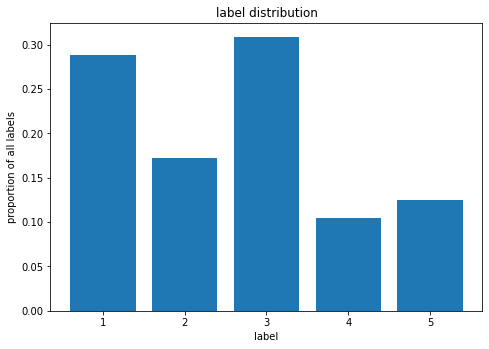

label counts:
 {1: 2839, 2: 1698, 3: 3039, 5: 1231, 4: 1024} 

label proportions:


{1: 0.28878038856677857,
 2: 0.17271895025938358,
 3: 0.3091241989624657,
 5: 0.1252161529854542,
 4: 0.10416030922591801}

In [16]:
# check out distribution of training set labels
get_distribution(stage1_train_ds)

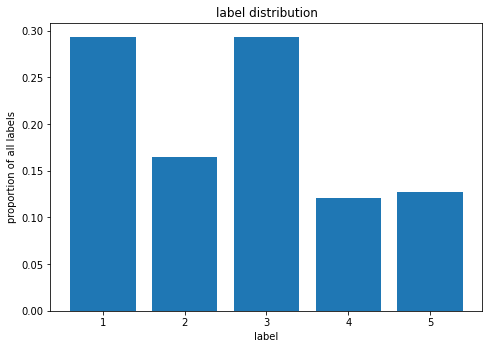

label counts:
 {1: 815, 2: 457, 3: 816, 5: 353, 4: 336} 

label proportions:


{1: 0.29348217500900253,
 2: 0.16456607850198054,
 3: 0.29384227583723443,
 5: 0.12711559236586245,
 4: 0.12099387828592006}

In [17]:
# check out distribution of dev set labels
get_distribution(stage1_dev_ds)

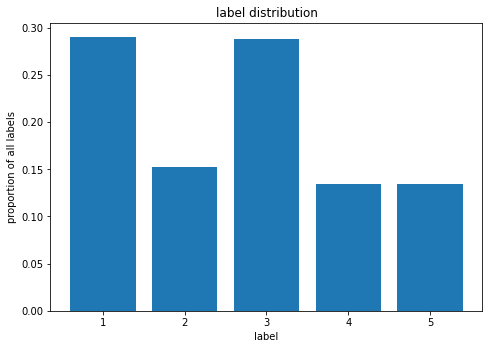

label counts:
 {1: 375, 3: 372, 5: 174, 2: 196, 4: 174} 

label proportions:


{1: 0.29047250193648333,
 3: 0.2881487219209915,
 5: 0.13477924089852827,
 2: 0.15182029434546862,
 4: 0.13477924089852827}

In [18]:
# check out distribution of test set labels
get_distribution(stage1_test_ds)

In [19]:
### Matt
# def shorten_txt_encoding(txt, shorten_by : int):       
#     pass...

# generate a list of docIds that have token collision after shortening

# toks = list(stage1_dev_ds.sample(1)['input_ids'])

# print(toks[0])

# tokenizer.decode(toks[0])

In [20]:
def batchify(tokenized_dataset, batch_size, device):
    num_examples = int(tokenized_dataset.shape[0] / batch_size)
    batch_sizes = [batch_size for x in range(num_examples)]
    last_batch_size = tokenized_dataset.shape[0] % batch_size
    if last_batch_size:
        batch_sizes.append(last_batch_size)
    # print(batch_sizes)

    batched_dataset = []

    idf_to_torch = lambda df : torch.tensor(np.array([list(map(int,r)) for r in df])).to(device)

    for idx, size in enumerate(batch_sizes):
        start = sum(batch_sizes[:idx])
        end = sum(batch_sizes[:idx]) + size - 1
        # print(start,end,idx)
        input_ids = idf_to_torch(tokenized_dataset['input_ids'].loc[start:end])
        attention_mask = idf_to_torch(tokenized_dataset['attention_mask'].loc[start:end])
        labels = idf_to_torch(tokenized_dataset['labels'].loc[start:end])
        doc_or_sent_id = list(tokenized_dataset['doc_or_sent_id'].loc[start:end])
        
        batch = {
            'input_ids':input_ids,
            'labels':labels,
            'attention_mask':attention_mask,
            'doc_or_sent_id':doc_or_sent_id

        }
        
        batched_dataset.append(batch)

    return batched_dataset

In [21]:
################# batchify ####################

batched_train_ds = batchify(stage1_train_ds[['attention_mask','input_ids','labels','doc_or_sent_id']], batch_size, device)
batched_dev_ds = batchify(stage1_dev_ds[['attention_mask','input_ids','labels','doc_or_sent_id']], batch_size, device)
batched_test_ds = batchify(stage1_test_ds[['attention_mask','input_ids','labels','doc_or_sent_id']], batch_size, device)


In [22]:
batched_train_ds[0]

{'input_ids': tensor([[    0,  3750, 46032,  ...,     1,     1,     1],
         [    0, 43958, 46032,  ...,     1,     1,     1],
         [    0,   970,    32,  ...,     1,     1,     1],
         ...,
         [    0,   133,  1007,  ...,     1,     1,     1],
         [    0,   133, 37920,  ...,     1,     1,     1],
         [    0, 44105,     4,  ...,     1,     1,     1]], device='cuda:0'),
 'labels': tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0'),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0'),
 'doc_or_sent_id': ['S0019103513005058-4098',
  'S0032063313003218-5381',
  'S09270248

In [23]:
demo_batch = 2

demo_batch = batched_train_ds[demo_batch]


demo_doc = demo_batch['doc_or_sent_id'][0]
demo_ids = demo_batch['input_ids'].cpu().numpy()[0]
demo_tokens = tokenizer.decode(demo_batch['input_ids'].cpu().numpy()[0])
demo_labels = demo_batch['labels'].cpu().numpy()[0]
demo_mask = demo_batch['attention_mask'].cpu().numpy()[0]
latch_print = False
labeled_tokens = ''
for id, lab in zip(demo_ids, demo_labels):
    if lab:
        labeled_tokens = labeled_tokens + tokenizer.decode(id) + ' '

print(task_map)


{'Quantity': 1, 'MeasuredProperty': 2, 'MeasuredEntity': 3, 'Qualifier': 4, 'Unit': 5}


In [24]:
demo_doc

'S016412121300188X-5038'

In [25]:
print(demo_ids)

[    0  1620    41  1948     7   248  1864   406     6    42   892  5684
    14  3867    89    16  1233  4885  7257  5137     9     5   467     6
 29977 18016 11729  1091  4375   148   467 10795     8  4634 19369     5
  2731  9437     9     5   586    11    70   130   403  3218     4  7543
   173    40 19795    42 45045   892    15    10   739  3260 42168     7
 29477   549    42  5443  3106    13    97  1767     4     2     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1   

In [26]:
print(demo_labels)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

In [27]:
print(demo_tokens)

<s>As an answer to RQ7, this study finds that unless there is significant refactoring of the system, coherent cluster profiles remain stable during system evolution and thus captures the core architecture of the program in all three case studies. Future work will replicate this longitudinal study on a large code corpus to ascertain whether this stability holds for other programs.</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad

In [28]:
combo_annot_processed

,docId,annotId,annotSet,annotType,annotSpan,subSpanType,linkId,linkSpan,subSpan,unit,unitEncoded,misc
comboId,,,,,,,,,,,,
S0006322312001096-1136_T1-1,S0006322312001096-1136,T1-1,1,Quantity,"[73, 77]",NaN,NaN,NaN,NaN,NaN,NaN,NaN
S0006322312001096-1136_T2-1,S0006322312001096-1136,T2-1,1,MeasuredEntity,"[49, 69]",HasQuantity,T1-1,"[73, 77]","[49, 77]",NaN,NaN,NaN
S0006322312001096-1136_T1-2,S0006322312001096-1136,T1-2,2,Quantity,"[103, 123]",NaN,NaN,NaN,NaN,NaN,NaN,{'mods': ['IsList']}
S0006322312001096-1136_T2-2,S0006322312001096-1136,T2-2,2,MeasuredEntity,"[79, 99]",HasQuantity,T1-2,"[103, 123]","[79, 123]",NaN,NaN,NaN
S0006322312001096-1136_T1-3,S0006322312001096-1136,T1-3,3,Quantity,"[205, 222]",NaN,NaN,NaN,NaN,participants,"[42038, 3277]",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
S2213671113001306-908_T1-2u,S2213671113001306-908,T1-2u,2,Unit,"[82, 84]",NaN,NaN,NaN,NaN,μm,NaN,NaN
S2213671113001306-910_T1-1u,S2213671113001306-910,T1-1u,1,Unit,"[907, 908]",NaN,NaN,NaN,NaN,×,NaN,NaN
S2213671113001306-910_T1-2u,S2213671113001306-910,T1-2u,2,Unit,"[980, 981]",NaN,NaN,NaN,NaN,×,NaN,NaN


In [29]:
demo_doc

'S016412121300188X-5038'

In [30]:
combo_annot_processed.loc[combo_annot_processed['docId']==demo_doc]

,docId,annotId,annotSet,annotType,annotSpan,subSpanType,linkId,linkSpan,subSpan,unit,unitEncoded,misc
comboId,,,,,,,,,,,,
S016412121300188X-5038_T1-1,S016412121300188X-5038,T1-1,1,Quantity,"[224, 229]",NaN,NaN,NaN,NaN,NaN,NaN,{'mods': ['IsCount']}
S016412121300188X-5038_T2-1,S016412121300188X-5038,T2-1,1,MeasuredEntity,"[230, 242]",HasQuantity,T1-1,"[224, 229]","[224, 242]",NaN,NaN,NaN


In [31]:
print(labeled_tokens)

 three  case  studies 


In [32]:
#### Stage 2 Stuff (not currently used)

# special_token_map = dict(zip(tokenizer.all_special_tokens,tokenizer.all_special_ids))

# demo_annots = combo_annot_processed.loc[combo_annot['docId']==demo_doc]

# demo_txt = combo_txt[demo_doc]

# encoded_demo_txt = tokenizer(demo_txt, padding='max_length', max_length=512, truncation=True)
# demo_token_startchar = []
# for idx, id in enumerate(encoded_demo_txt['input_ids']):
#     try: tokenCharStart = encoded_demo_txt.token_to_chars(idx).start
#     except: tokenCharStart = np.nan
#     demo_token_startchar.append(tokenCharStart)

# subSpan_ds = {}
# for comboId, annot in demo_annots.iterrows():
#     if isinstance(annot['subSpanType'],float): continue # nans are floats
#     print(comboId)
#     print(annot['annotType'])
#     print(annot['subSpanType'])
#     print(annot['subSpan'][0],annot['subSpan'][1])
#     subSpanRange = list(range(annot['subSpan'][0],annot['subSpan'][1]))
#     # print(subSpanRange)
#     subSpanIds = []
#     subSpanLabels = []
#     for id, label, startChar in zip(demo_ids, demo_labels, demo_token_startchar):
#         if startChar in subSpanRange:
#             subSpanIds.append(id)
#             subSpanLabels.append(label)
#     print(subSpanIds)
#     print(subSpanLabels)
#     print(tokenizer.decode(subSpanIds,skip_special_tokens=True))
#     print()



In [33]:
class Stage1model(nn.Module):
    def __init__(self, dropout=dropout_rate):
        super(Stage1model, self).__init__()
        self.mod = RobertaModel.from_pretrained(
                    model_name,
                    num_labels=num_classes+1,
                    hidden_dropout_prob=dropout,
                    output_hidden_states=True)
        if normalizer_before_class: 
            self.norm = nn.BatchNorm1d(512, eps=self.mod.config.layer_norm_eps)
        self.drop = nn.Dropout(self.mod.config.hidden_dropout_prob)
        self.classifier = nn.Linear(self.mod.config.hidden_size, num_classes+1)

    def forward(self, input_ids, attention_mask):
        output = self.mod(input_ids=input_ids,attention_mask=attention_mask)
        y_hat = output.hidden_states[-1]
        if normalizer_before_class: y_hat = self.norm(y_hat)
        y_hat = self.drop(y_hat)
        y_hat = self.classifier(y_hat).permute(0,2,1)
        return y_hat

model = Stage1model().to(device)

model_new = model


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [34]:
model

Stage1model(
  (mod): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.03, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), 

In [35]:
criterion = torch.nn.CrossEntropyLoss(reduction='sum')
optimizer = AdamW(model.parameters(), lr=learning_rate)

n_training_steps = n_epochs * len(batched_train_ds)

if use_lr_scheduler:
    n_training_steps = n_epochs * len(batched_train_ds)
    lr_scheduler = get_scheduler(
        name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=n_training_steps
    )


def train_epoch(ds, criterion):

    model.train()

    ypred = []
    ytrue = []
    loss_log = []
    for idx, batch in enumerate(ds):

        labels = batch['labels']
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        
        optimizer.zero_grad()

        logits = model(input_ids, attention_mask)
        
        loss = criterion(logits, labels)
        loss_log.append(loss.item())
        
        loss.backward()
        optimizer.step()
        if use_lr_scheduler: lr_scheduler.step()

        progress_bar.update(1)
            
    return loss_log



def eval_epoch(ds, criterion):

    model.eval()

    ypred = []
    ytrue = []
    loss_log = []
    with torch.no_grad():
        for idx, batch in enumerate(ds):

            labels = batch['labels']
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']

            logits = model(input_ids, attention_mask)
            
            loss = criterion(logits, labels)
            loss_log.append(loss.item())

            for dlogits, dlabels in zip(logits.permute(0,2,1), labels):
                    for tlogits, tlabels in zip(dlogits, dlabels):
                        ypred.append(tlogits.argmax().item())
                        ytrue.append(tlabels.item())

            progress_bar.update(1)

    acc = metrics.accuracy_score(ytrue,ypred)
    report = classification_report(ytrue,ypred,
                                    labels=list(task_map.values()),
                                    target_names=list(task_map.keys()),
                                    output_dict=True,
                                    zero_division=0)

                                    

    return loss_log, acc, report, ytrue, ypred

In [36]:
run_report = {  'epoch':[],
                'train_loss':[],
                'eval_train_loss':[],
                'eval_train_acc':[],
                'eval_train_ytrue':[],
                'eval_train_ypred':[],
                'eval_train_rpt':[],
                'eval_dev_loss':[],
                'eval_dev_acc':[],
                'eval_dev_ytrue':[],
                'eval_dev_ypred':[],
                'eval_dev_rpt':[],
             }

num_total_steps = n_epochs * (len(batched_train_ds) * 2 + len(batched_dev_ds))
progress_bar = tqdm(range(num_total_steps))

for epoch in range(n_epochs):
    run_report['epoch'].append(epoch)
    
    print(f"============ Begin Epoch {epoch+1} ============")

    loss = train_epoch(batched_train_ds, criterion)
    print(f"Last train batch loss: {loss[-1]}")
    run_report['train_loss'].extend(loss)
    
    output = eval_epoch(batched_train_ds, criterion)
    (loss, acc, report, ytrue, ypred) = output
    print(f'Eval on train set bast batch loss: {loss[-1]}   accuracy: {acc}')
    run_report['eval_train_loss'].extend(loss)
    run_report['eval_train_acc'].append(acc)
    run_report['eval_train_ytrue'].append(ytrue)
    run_report['eval_train_ypred'].append(ypred)
    run_report['eval_train_rpt'].append(report)

    output = eval_epoch(batched_dev_ds, criterion)
    (loss, acc, report, ytrue, ypred) = output
    print(f'Eval on dev set last batch loss: {loss[-1]}   accuracy: {acc}')
    run_report['eval_dev_loss'].extend(loss)
    run_report['eval_dev_acc'].append(acc)
    run_report['eval_dev_ytrue'].append(ytrue)
    run_report['eval_dev_ypred'].append(ypred)
    run_report['eval_dev_rpt'].append(report)
    


  0%|          | 0/736 [00:00<?, ?it/s]

============ Begin Epoch 1 ============
Last train batch loss: 24.593708038330078
Eval on train set bast batch loss: 22.44321632385254   accuracy: 0.9569566082802548
Eval on dev set last batch loss: 49.875816345214844   accuracy: 0.9577256944444444
============ Begin Epoch 2 ============
Last train batch loss: 13.533740997314453
Eval on train set bast batch loss: 12.537714004516602   accuracy: 0.9711012141719745
Eval on dev set last batch loss: 48.99689483642578   accuracy: 0.9647135416666667
============ Begin Epoch 3 ============
Last train batch loss: 7.180195331573486
Eval on train set bast batch loss: 6.643858432769775   accuracy: 0.9775763833598726
Eval on dev set last batch loss: 42.359004974365234   accuracy: 0.9679904513888888
============ Begin Epoch 4 ============
Last train batch loss: 5.8890581130981445
Eval on train set bast batch loss: 2.754251480102539   accuracy: 0.9830003483280255
Eval on dev set last batch loss: 86.68136596679688   accuracy: 0.9608072916666667
======

['NoLabel', 'Quantity', 'MeasuredProperty', 'MeasuredEntity', 'Qualifier', 'Unit']
[[42930    47    83   197    34    12]
 [  186   611     0     1     2    15]
 [  152     3   254    26    20     2]
 [  256     3    93   418    46     0]
 [  174     7    37    50    64     4]
 [   40     4     1     4     0   304]]


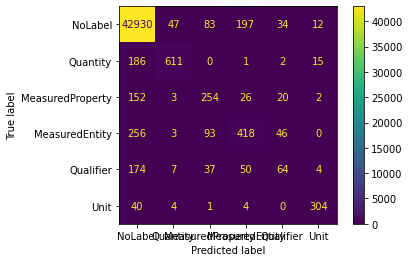

In [37]:
display_labels = list(task_map.keys())
display_labels.insert(0,str('NoLabel'))
print(display_labels)
cm = confusion_matrix(ytrue,ypred)
print(cm)
ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=display_labels).plot()
plt.show()

In [38]:

ypred_by_doc = {}
ytrue_by_doc = {}
for i, doc in enumerate(dev_docs):

    ypred_by_doc[doc] = ypred[i*512:(i+1)*512]
    ytrue_by_doc[doc] = ytrue[i*512:(i+1)*512]

    # print(f'aligned {len(ypred_by_doc[doc])} predictions into doc {doc}')

#### Test doc-to-label alignment
for test_doc in dev_docs:
    input_lab = stage1_dev_ds.loc[stage1_dev_ds['doc_or_sent_id']==test_doc]['labels']
    assert ytrue_by_doc[test_doc] == list(input_lab.values[0])

In [39]:
epoch = 0
run_report['eval_train_rpt'][epoch]['weighted avg']['f1-score']

0.3430169624753648

In [40]:
def tabulate_metrics(reports):
    metrics = []
    for epoch in reports:
        # print(epoch)
        epoch_metrics = {}
        for task, rpt in task_map.items():
            # print(task)
            for metric, value in epoch[task].items():
                epoch_metrics[str(task+'_'+metric)] = value
        epoch_metrics['wt_f1'] = epoch['weighted avg']['f1-score']
        metrics.append(epoch_metrics)

    metrics = pd.DataFrame.from_dict(metrics)
    metrics.index.rename('epoch')
    return metrics
train_set_metrics = tabulate_metrics(run_report['eval_train_rpt'])
train_set_metrics

,Quantity_precision,Quantity_recall,Quantity_f1-score,Quantity_support,MeasuredProperty_precision,MeasuredProperty_recall,MeasuredProperty_f1-score,MeasuredProperty_support,MeasuredEntity_precision,MeasuredEntity_recall,...,MeasuredEntity_support,Qualifier_precision,Qualifier_recall,Qualifier_f1-score,Qualifier_support,Unit_precision,Unit_recall,Unit_f1-score,Unit_support,wt_f1
0,0.805838,0.836210,0.820743,2839,0.000000,0.000000,0.000000,1698,0.375000,0.006910,...,3039,0.000000,0.000000,0.000000,1024,0.806555,0.819659,0.813054,1231,0.343017
1,0.847812,0.928144,0.886161,2839,0.730129,0.232627,0.352836,1698,0.641900,0.520237,...,3039,0.680000,0.016602,0.032412,1024,0.824380,0.972380,0.892285,1231,0.609606
2,0.891594,0.941529,0.915881,2839,0.819767,0.249117,0.382114,1698,0.765058,0.714709,...,3039,0.756677,0.249023,0.374724,1024,0.865650,0.968318,0.914110,1231,0.712431
3,0.862819,0.963720,0.910483,2839,0.657130,0.852179,0.742051,1698,0.776626,0.813425,...,3039,0.632139,0.637695,0.634905,1024,0.855216,0.978879,0.912879,1231,0.817165
4,0.954089,0.936950,0.945442,2839,0.703133,0.832744,0.762470,1698,0.903071,0.803225,...,3039,0.990415,0.302734,0.463725,1024,0.894231,0.982128,0.936121,1231,0.833063
5,0.922663,0.966538,0.944091,2839,0.721542,0.936985,0.815270,1698,0.875974,0.887792,...,3039,0.862891,0.565430,0.683186,1024,0.863701,0.993501,0.924065,1231,0.872915
6,0.972163,0.971821,0.971992,2839,0.949468,0.840989,0.891943,1698,0.916720,0.941757,...,3039,0.807692,0.881836,0.843137,1024,0.946094,0.983753,0.964556,1231,0.930545
7,0.991616,0.916520,0.952590,2839,0.932730,0.971731,0.951832,1698,0.977688,0.951629,...,3039,0.939873,0.870117,0.903651,1024,0.983912,0.943948,0.963516,1231,0.952406


In [41]:
dev_set_metrics = tabulate_metrics(run_report['eval_dev_rpt'])
dev_set_metrics

,Quantity_precision,Quantity_recall,Quantity_f1-score,Quantity_support,MeasuredProperty_precision,MeasuredProperty_recall,MeasuredProperty_f1-score,MeasuredProperty_support,MeasuredEntity_precision,MeasuredEntity_recall,...,MeasuredEntity_support,Qualifier_precision,Qualifier_recall,Qualifier_f1-score,Qualifier_support,Unit_precision,Unit_recall,Unit_f1-score,Unit_support,wt_f1
0,0.803378,0.817178,0.810219,815,0.000000,0.000000,0.000000,457,0.304348,0.008578,...,816,0.000000,0.000000,0.000000,336,0.833333,0.878187,0.855172,353,0.351394
1,0.812646,0.851534,0.831636,815,0.619835,0.164114,0.259516,457,0.535529,0.378676,...,816,1.000000,0.014881,0.029326,336,0.803783,0.963173,0.876289,353,0.532078
2,0.838710,0.893252,0.865122,815,0.773585,0.179431,0.291297,457,0.581690,0.506127,...,816,0.723404,0.101190,0.177546,336,0.826829,0.960340,0.888598,353,0.595324
3,0.779046,0.921472,0.844295,815,0.444795,0.617068,0.516957,457,0.457510,0.567402,...,816,0.290000,0.258929,0.273585,336,0.796253,0.963173,0.871795,353,0.625630
4,0.876984,0.813497,0.844048,815,0.529412,0.531729,0.530568,457,0.624801,0.481618,...,816,0.750000,0.053571,0.100000,336,0.794457,0.974504,0.875318,353,0.618226
5,0.863962,0.888344,0.875983,815,0.429421,0.632385,0.511504,457,0.548309,0.556373,...,816,0.348837,0.133929,0.193548,336,0.772124,0.988669,0.867081,353,0.637192
6,0.869077,0.855215,0.862090,815,0.657371,0.361050,0.466102,457,0.574866,0.526961,...,816,0.348148,0.279762,0.310231,336,0.840686,0.971671,0.901445,353,0.643412
7,0.905185,0.749693,0.820134,815,0.542735,0.555799,0.549189,457,0.600575,0.512255,...,816,0.385542,0.190476,0.254980,336,0.902077,0.861190,0.881159,353,0.636401


In [42]:
with open(runoutpath+'ypred.json','w') as f:
    json.dump(ypred_by_doc, f)

with open(runoutpath+'ytrue.json','w') as f:
    json.dump(ytrue_by_doc, f)

with open(runoutpath+'ypred_by_doc.json','w') as f:
    json.dump(ypred_by_doc, f)

with open(runoutpath+'ytrue_by_doc.json','w') as f:
    json.dump(ytrue_by_doc, f)

dev_set_metrics.to_csv(runoutpath+'dev_set_metrics')

train_set_metrics.to_csv(runoutpath+'train_set_metrics')

In [43]:
len(batched_dev_ds)

12

In [44]:
run_report['epoch'][-1]+1

8

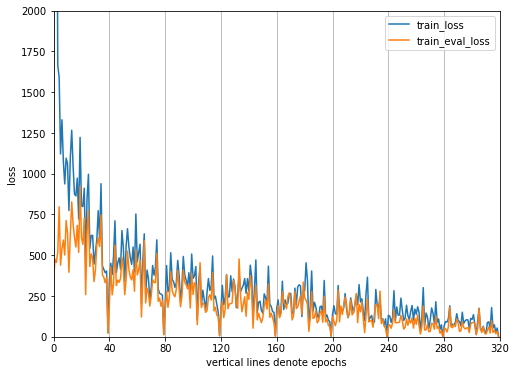

In [45]:
########################## loss plot #######################

n_batches = len(batched_train_ds)
n_epochs = len(run_report['epoch'])
n_steps = n_epochs*n_batches
steps = np.array(range(n_steps))
train_loss = np.array(run_report['train_loss'])
train_eval_loss = np.array(run_report['eval_train_loss'])

fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(8,6))
tics = plticker.MultipleLocator(n_batches)
ax.xaxis.set_major_locator(tics)
ax.set_xlim(0,n_steps)
ax.set_ylim(0,2000)
ax.plot(steps,train_loss,label='train_loss')
ax.plot(steps,train_eval_loss,label='train_eval_loss')

plt.grid(axis='x')
plt.legend()
plt.ylabel('loss')
plt.xlabel('vertical lines denote epochs')
plt.show()

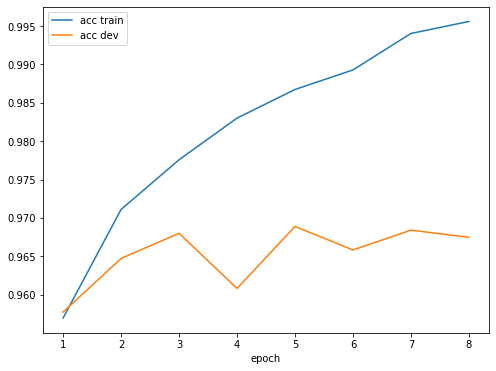

In [49]:
########################## dev set accuracy plot #######################

epoch = np.array(range(len(run_report['epoch'])))
ytrain = np.array(run_report['eval_train_acc'])
ydev = np.array(run_report['eval_dev_acc'])


fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(8,6))
ax.plot(epoch+1,ytrain, label='acc train')
ax.plot(epoch+1,ydev, label='acc dev')
plt.legend()
plt.xlabel('epoch')
plt.show()

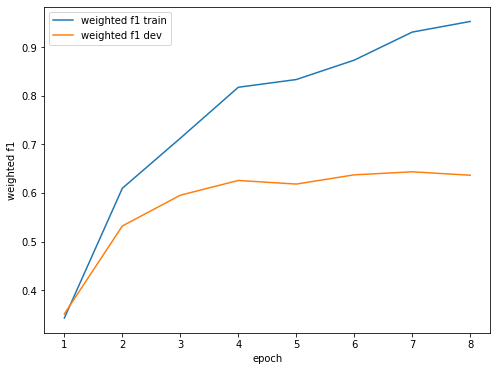

In [48]:
########################## weighted f1 plot #######################

epoch = np.array(range(len(run_report['epoch'])))
ytrain = np.array(train_set_metrics['wt_f1'])
ydev = np.array(dev_set_metrics['wt_f1'])


fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(8,6))
ax.plot(epoch+1,ytrain, label='weighted f1 train')
ax.plot(epoch+1,ydev, label='weighted f1 dev')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('weighted f1')
plt.show()